# Statistics
Plot all kinds of interesting statistics about the measured flux table

In [1]:
import sys
from src.flux_sampler import FluxSampler
from src.flux_component_analysis import FluxComponentAnalysis
from uncertainties import nominal_value, std_dev
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import src.settings as S
from sklearn.decomposition import PCA

fca = FluxComponentAnalysis()
meta_df = fca.meta_df
meta_df = meta_df[meta_df['absolute flux?'] == 1]

flux_df = fca.flux_df.loc[meta_df.index, :]
flux_df.drop([
    "redox",
    "respiration",
    "aceA_aceB",
    "mgsA",
], axis=1, inplace=True)

SyntaxError: invalid syntax (<ipython-input-1-44297609a0c4>, line 2)

In [3]:
print(f"{meta_df.shape[0]} absolute fluxes measured")

107 absolute fluxes measured


In [4]:
def get_counts(col):
    return meta_df[[col]].fillna('').groupby([col]).size().sort_values().to_frame()

In [5]:
get_counts('species')

0
species           
A. tumefaciens   1
B. subtilis      1
P. fluorescens   1
P. putida        1
P. versutus      1
R. sphaeroides   1
S. meliloti      1
Z. mobilis       1
E. coli         99

In [6]:
get_counts('original source')

0
original source    
Fischer_2003      3
Gruber_2018       7
Gerosa_2015       8
Fuhrer_2005      10
Schuetz_2012     10
Nanchen_2006     17
Perrenoud_2005   21
Ishii_2007       31

In [7]:
get_counts('condition')

0
condition           
bioreactor         1
deep-well plates   1
chemostat         48
shake flask       57

Text(0.5, 1.0, 'Histogram of measured growth rates')

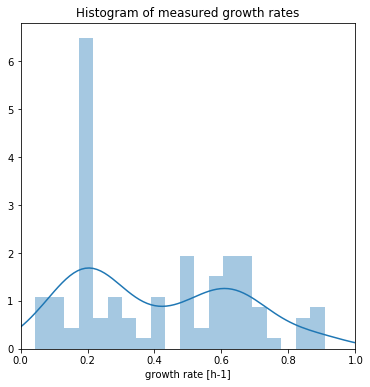

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
sns.distplot(meta_df['growth rate [h-1]'].apply(nominal_value).dropna(),
             bins=20, kde_kws={'bw':0.1}, ax=ax)
ax.set_xlim(0, 1.0)
ax.set_title('Histogram of measured growth rates')

In [9]:
# Check consistency between similar samples
params = {'species': 'E. coli',
          'condition': 'shake flask',
          'strain': 'MG1655',
          'mutation': 'wild-type',
          'temperature': 37,
          'medium': 'M9 + glucose'}

_df = meta_df
for k, v in params.items():
    _df = _df[_df[k] == v]
_df

original source direct source  species  strain   mutation  \
serial number                                                             
1                Schuetz_2012  Schuetz_2012  E. coli  MG1655  wild-type   
3                Schuetz_2012  Schuetz_2012  E. coli  MG1655  wild-type   
4                Schuetz_2012  Schuetz_2012  E. coli  MG1655  wild-type   
5                Fischer_2003  Schuetz_2012  E. coli  MG1655  wild-type   
55                Fuhrer_2005   Fuhrer_2005  E. coli  MG1655  wild-type   
126               Gruber_2018   Gruber_2018  E. coli  MG1655  wild-type   

              Strain Background            person    condition temperature  \
serial number                                                                
1                           NaN   Annik Perrenoud  shake flask          37   
3                           NaN   Annik Perrenoud  shake flask          37   
4                           NaN   Annik Perrenoud  shake flask          37   
5              F- lambda- rph-1    Eliane Fischer  shake flask          37   
55                          NaN     Tobias Fuhrer  shake flask          37   
126                         NaN  Christoph Gruber  shake flask          37   

                     medium growth rate [h-1] absolute flux?    Biomass Model  \
serial number                                                                   
1              M9 + glucose     0.670+/-0.010           True           e_coli   
3              M9 + glucose     0.650+/-0.010           True           e_coli   
4              M9 + glucose     0.610+/-0.028           True           e_coli   
5              M9 + glucose     0.610+/-0.010           True           e_coli   
55             M9 + glucose     0.414+/-0.010           True           e_coli   
126            M9 + glucose     0.620+/-0.020           True  e_coli_fiatflux   

              fermentation $h^{comb}$ [kJ gCDW$^{-1}$ h$^{-1}$]  \
serial number                                                     
1                                                     7.2+/-0.4   
3                                                     5.7+/-0.7   
4                                                     3.9+/-0.5   
5                                                     3.9+/-0.4   
55                                                  3.12+/-0.10   
126                                                 3.16+/-0.19   

              import $h^{comb}$ [kJ gCDW$^{-1}$ h$^{-1}$]  \
serial number                                               
1                                             -30.8+/-1.0   
3                                             -26.8+/-1.7   
4                                             -24.5+/-1.3   
5                                             -25.1+/-0.6   
55                                            -22.2+/-0.5   
126                                           -21.1+/-0.8   

              precursor $h^{comb}$ [kJ gCDW$^{-1}$ h$^{-1}$]  \
serial number                                                  
1                                                 16.3+/-1.1   
3                                                 15.3+/-2.0   
4                                                 14.5+/-1.6   
5                                                 14.7+/-0.6   
55                                              17.87+/-0.26   
126                                               15.5+/-1.1   

              $g^{diss}$ [kJ gCDW$^{-1}$ h$^{-1}$]  \
serial number                                        
1                                        7.2+/-1.0   
3                                        6.1+/-1.3   
4                                        6.1+/-1.0   
5                                        6.3+/-0.9   
55                                     5.04+/-0.25   
126                                      6.4+/-0.6   

              biomass $h^{comb}$ [kJ gCDW$^{-1}$ h$^{-1}$]  
serial number                                               
1                                            

In [10]:
# compare fluxes of the same strain and conditions:
def compare_fluxes(i1, i2):
    x1 = flux_df.loc[i1, :].apply(nominal_value)
    x2 = flux_df.loc[i2, :].apply(nominal_value)
    fig, ax = plt.subplots(1, 1, figsize=(9, 9))
    ax.plot(x1, x2, '.')
    for rxn in x1.index:
        ax.text(x1[rxn] + 0.1, x2[rxn], rxn)
    ax.plot([0, 17], [0, 17], '-')
    ax.set_title('Comparing absolute fluxes')
    ax.set_xlabel(meta_df.at[i1, "original source"] + ', ' + meta_df.at[i1, "medium"])
    ax.set_ylabel(meta_df.at[i2, "original source"] + ', ' + meta_df.at[i2, "medium"])

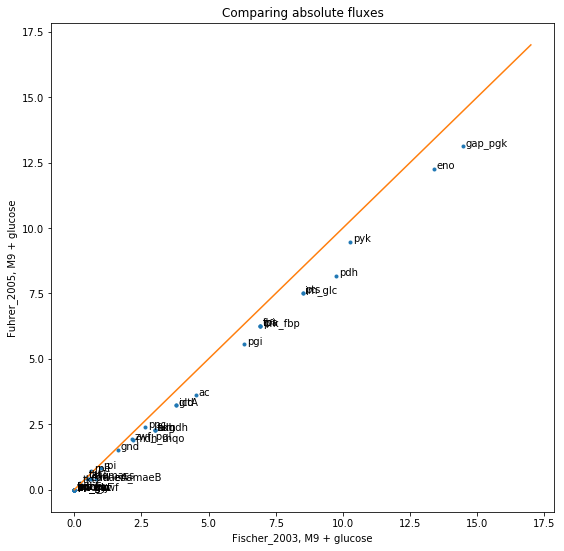

In [11]:
compare_fluxes(5, 55)

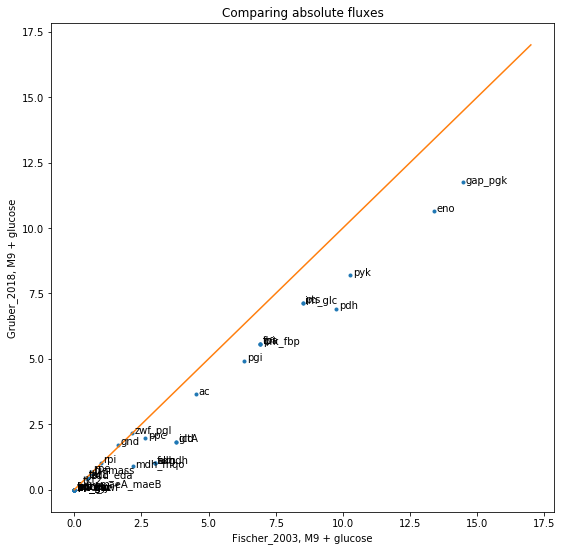

In [12]:
compare_fluxes(5, 126)

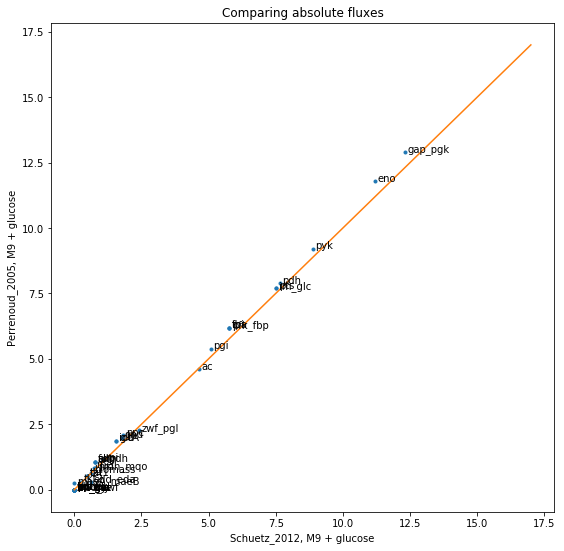

In [13]:
compare_fluxes(14, 18)

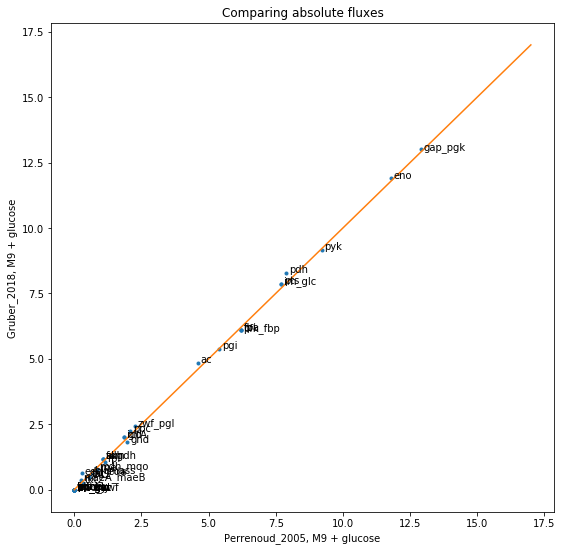

In [14]:
# E. coli, BW25113, glucose, shake flask
compare_fluxes(18, 127)

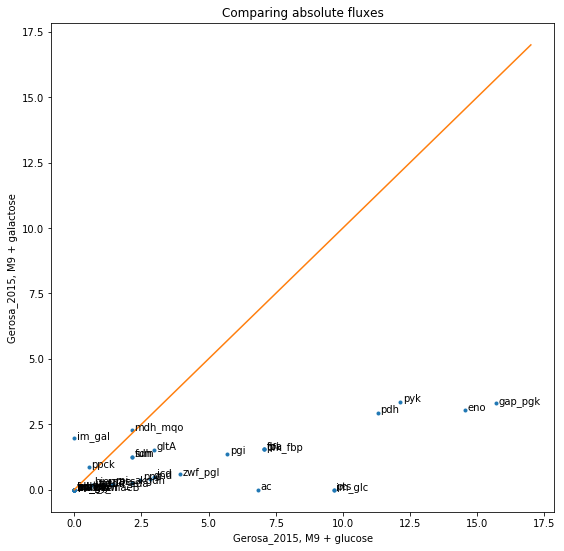

In [15]:
# E. coli, BW25113, glucose, shake flask
compare_fluxes(121, 120)

## Flux Variability Analysis

Text(0, 0.5, 'PC2 (0.16)')

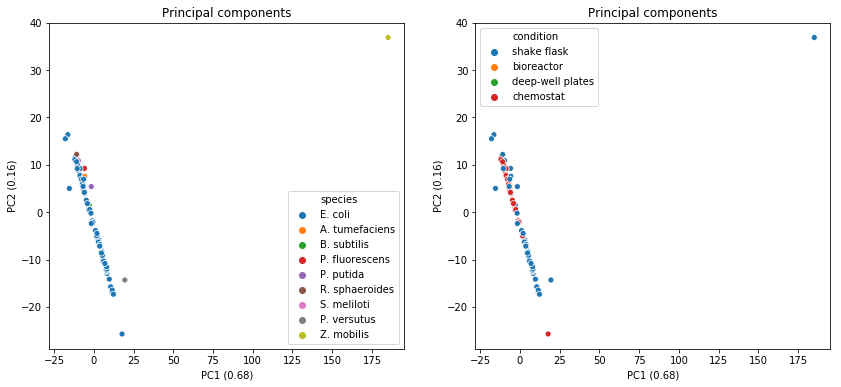

In [16]:
from sklearn.decomposition import PCA

X = flux_df.applymap(nominal_value).values

pca = PCA(n_components=2)
pca.fit(X)
X2 = pca.transform(X)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(X2[:, 0], X2[:, 1], hue=meta_df['species'], ax=axs[0])
axs[0].set_title('Principal components')
axs[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
axs[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

sns.scatterplot(X2[:, 0], X2[:, 1], hue=meta_df['condition'], ax=axs[1])
axs[1].set_title('Principal components')
axs[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
axs[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

Text(0, 0.5, 'PC2 (0.09)')

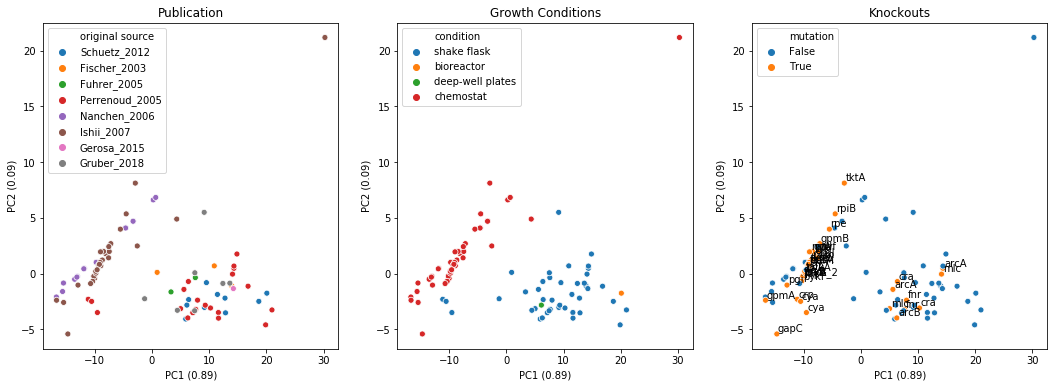

In [17]:
ecoli_meta_df = meta_df[(meta_df.species == 'E. coli') & (meta_df.medium == 'M9 + glucose')]
ecoli_flux_df = flux_df.loc[ecoli_meta_df.index, :]

X = ecoli_flux_df.applymap(nominal_value).values

pca = PCA(n_components=2)
pca.fit(X)
X2 = pca.transform(X)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = axs[0]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=ecoli_meta_df['original source'], ax=ax)
ax.set_title('Publication')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

ax = axs[1]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=ecoli_meta_df['condition'], ax=ax)
ax.set_title('Growth Conditions')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

ax = axs[2]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=(ecoli_meta_df['mutation'] != 'wild-type'), ax=ax)
for x, y, label in zip(X2[:, 0], X2[:, 1], ecoli_meta_df['mutation']):
    if label != 'wild-type':
        ax.text(x+0.2, y+0.2, label)
ax.set_title('Knockouts')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

R^2 = 0.91


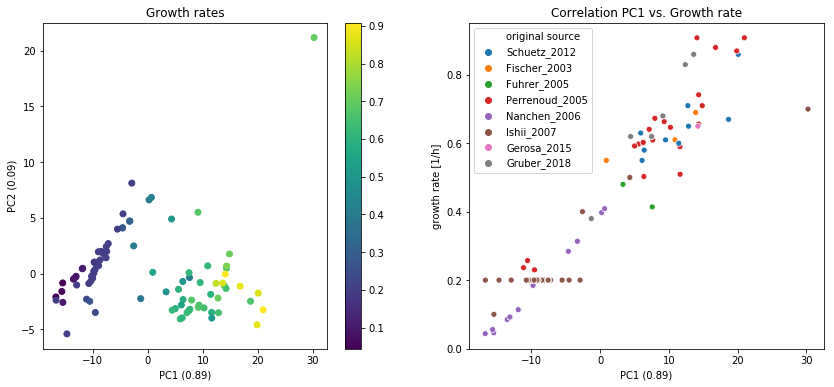

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

growth_rate = ecoli_flux_df['biomass'].apply(nominal_value)

ax = axs[0]
mappable2 = ax.scatter(X2[:, 0], X2[:, 1], c=growth_rate)
ax.set_title('Growth rates')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.colorbar(mappable2, ax=ax)

ax = axs[1]
sns.scatterplot(X2[:, 0], growth_rate, hue=ecoli_meta_df['original source'], ax=ax)
ax.set_title('Correlation PC1 vs. Growth rate')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'growth rate [1/h]')

print(f"R^2 = {np.corrcoef(X2[:, 0], growth_rate)[0, 1]**2:.2f}")

Text(0, 0.5, 'PC2 (0.16)')

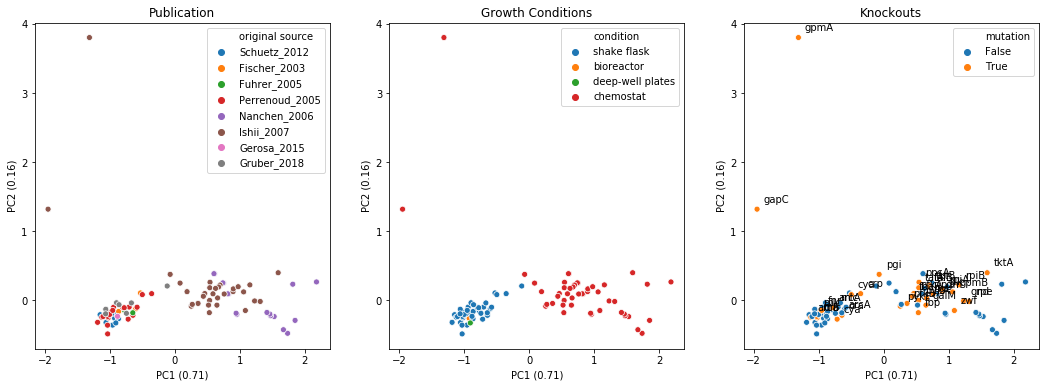

In [19]:
rel_ecoli_flux_df = ecoli_flux_df.div(ecoli_flux_df['im_glc'].apply(nominal_value), axis=0)

X = rel_ecoli_flux_df.applymap(nominal_value).values

pca = PCA(n_components=2)
pca.fit(X)
X2 = pca.transform(X)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

ax = axs[0]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=ecoli_meta_df['original source'], ax=ax)
ax.set_title('Publication')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

ax = axs[1]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=ecoli_meta_df['condition'], ax=ax)
ax.set_title('Growth Conditions')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

ax = axs[2]
sns.scatterplot(X2[:, 0], X2[:, 1], hue=(ecoli_meta_df['mutation'] != 'wild-type'), ax=ax)
for x, y, label in zip(X2[:, 0], X2[:, 1], ecoli_meta_df['mutation']):
    if label != 'wild-type':
        ax.text(x+0.1, y+0.1, label)
ax.set_title('Knockouts')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')

R^2 = 0.56


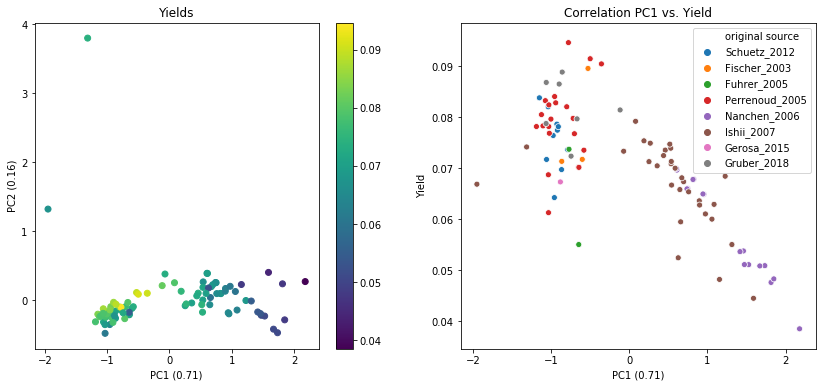

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

biomass_yield = rel_ecoli_flux_df['biomass'].apply(nominal_value)

ax = axs[0]
mappable2 = ax.scatter(X2[:, 0], X2[:, 1], c=biomass_yield)
ax.set_title('Yields')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
plt.colorbar(mappable2, ax=ax)

ax = axs[1]
sns.scatterplot(X2[:, 0], biomass_yield, hue=ecoli_meta_df['original source'], ax=ax)
ax.set_title('Correlation PC1 vs. Yield')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'Yield')

print(f"R^2 = {np.corrcoef(X2[:, 0], biomass_yield)[0, 1]**2:.2f}")

In [56]:
fsampler = FluxSampler()
f_smpl = fsampler.multisample(100, n_bins=10)
f_smpl = f_smpl[flux_df.columns]

Text(0, 0.5, 'PC2')

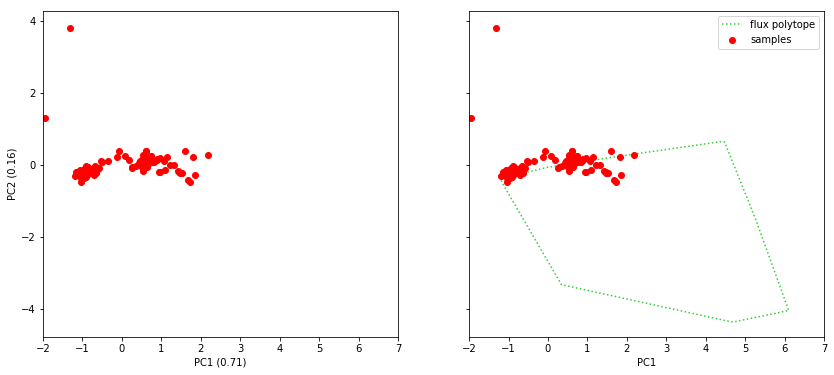

In [60]:
biomass_yield = rel_ecoli_flux_df['biomass'].apply(nominal_value)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
ax = axs[0]
mappable2 = ax.scatter(X2[:, 0], X2[:, 1], c='red')
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2f})')
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2f})')
ax.set_xlim(-2, 7)

ax = axs[1]
decomp_df = pd.DataFrame(pca.components_.T,
                         index=rel_ecoli_flux_df.columns,
                         columns=["PC1", "PC2"])
ppp = fsampler.phenotypic_phase_plane(decomp_df["PC1"],
                                      decomp_df["PC2"])
ppp.columns = ["PC1", "PC2"]
ppp.plot(x="PC1", y="PC2", ax=ax, style=':',
         zorder=0, color=(0.2, 0.8, 0.2),
         label='flux polytope')
ax.scatter(X2[:, 0], X2[:, 1], c='red', label='samples')
ax.set_xlim(-2, 7)
ax.legend(loc='best')
ax.set_ylabel("PC2")

(-2, 7)

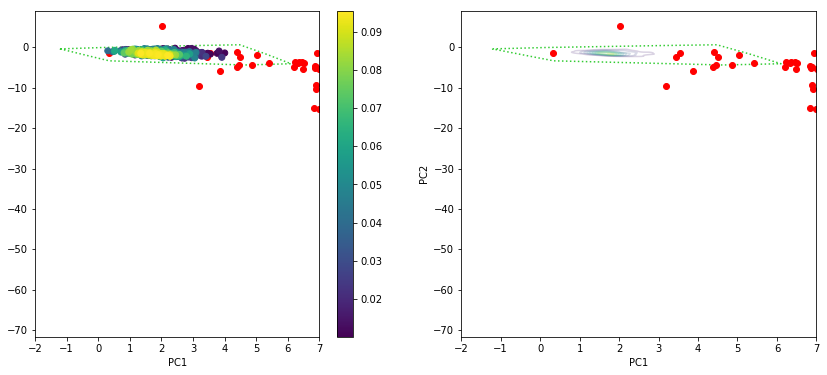

In [81]:
X_smpl = f_smpl.dot(decomp_df)
X_meas = flux_df.dot(decomp_df).applymap(nominal_value)

biomass_yield = rel_ecoli_flux_df['biomass'].apply(nominal_value)

fig, axs = plt.subplots(1, 2, figsize=(14, 6))
ax = axs[0]
ax.scatter(X_meas["PC1"], X_meas["PC2"], c='red')
mappable2 = ax.scatter(X_smpl["PC1"], X_smpl["PC2"], c=f_smpl.biomass)
plt.colorbar(mappable2, ax=ax)
ppp.plot(x="PC1", y="PC2", ax=ax, style=':',
         zorder=0, color=(0.2, 0.8, 0.2), legend=False)
ax.set_xlim(-2, 7)

ax = axs[1]
ax.scatter(X_meas["PC1"], X_meas["PC2"], c='red')
ppp.columns = ["PC1", "PC2"]
sns.kdeplot(X_smpl["PC1"], X_smpl["PC2"], cmap='viridis',
            zorder=0, ax=ax, alpha=0.2)
ppp.plot(x="PC1", y="PC2", ax=ax, style=':',
         zorder=0, color=(0.2, 0.8, 0.2), legend=False)
ax.set_xlim(-2, 7)


In [82]:
decomp_df

PC1           PC2
reaction                             
biomass   -8.727083e-03 -7.914267e-04
im_glc    -1.110223e-16  2.775558e-17
im_ac     -0.000000e+00  1.110223e-16
im_fru    -0.000000e+00  1.110223e-16
im_gal    -0.000000e+00 -0.000000e+00
im_gly    -0.000000e+00 -0.000000e+00
im_gln    -0.000000e+00 -0.000000e+00
im_suc    -0.000000e+00 -0.000000e+00
im_pyr    -0.000000e+00 -0.000000e+00
pts       -0.000000e+00 -0.000000e+00
zwf_pgl   -1.695279e-02 -1.115436e-02
zmo_zwf   -0.000000e+00 -1.577722e-30
gnd       -1.571151e-02 -2.666951e-03
rpi       -1.456060e-02  8.249772e-04
rpe       -1.812410e-03 -3.473991e-03
pgi        1.556479e-02  6.797032e-03
edd_eda   -1.218753e-03 -8.455815e-03
pfk_fbp    1.398410e-02  2.430675e-03
fba        1.398410e-02  2.430675e-03
tpi        1.398410e-02  2.430675e-03
tkt1      -1.547022e-03 -1.000506e-03
tkt2      -2.653877e-04 -2.473485e-03
tal       -1.547022e-03 -1.000506e-03
gap_pgk    5.942282e-02 -3.477434e-01
eno        1.073561e-01 -4.019750e-01
pyk        2.240369e-01 -3.602944e-01
pdh        2.490030e-01 -3.289774e-01
gltA       3.778171e-01 -8.327997e-03
icd        2.668039e-01  4.224213e-02
akgdh      2.280859e-01  6.460835e-01
sdh        3.853170e-01  1.836599e-02
fum        3.853170e-01  1.836599e-02
mdh_mqo    4.824506e-01 -1.359531e-02
maeA_maeB  1.390688e-02 -1.859862e-02
ppc       -1.111978e-01 -2.474790e-02
ppck      -5.626041e-04 -6.319005e-04
pc        -6.383048e-05  9.954302e-05
ac        -2.507558e-01 -2.409731e-01
adh        4.249860e-04  2.420232e-04
pyrex     -0.000000e+00 -0.000000e+00
fumex     -1.004156e-10 -1.127857e-10
ldh        4.300385e-05  1.014584e-05

In [80]:
X2

PC1                      PC2
serial number                                                 
1                          11.5+/-0.6              -22.5+/-0.6
2                          12.4+/-0.6              -22.5+/-0.8
3                           9.1+/-0.8              -19.2+/-0.9
4                          10.5+/-0.7              -15.9+/-0.8
5                        12.39+/-0.29            -16.31+/-0.29
6                           8.4+/-0.5              -12.7+/-0.6
7                           8.8+/-0.6              -18.5+/-0.6
8                           8.5+/-1.1              -14.8+/-1.4
9                         9.70+/-0.35              -23.5+/-0.4
10                         10.3+/-0.7              -17.7+/-0.8
11                         10.1+/-0.9              -18.5+/-0.9
12                       11.56+/-0.29            -18.91+/-0.32
13                         14.3+/-0.6              -18.3+/-0.6
14                        6.84+/-0.16            -15.06+/-0.17
15                        8.47+/-0.22            -16.46+/-0.23
16                          8.1+/-0.5              -14.9+/-0.5
17                        9.40+/-0.20            -10.37+/-0.21
18                        7.59+/-0.22            -15.48+/-0.23
19                        9.17+/-0.28            -13.84+/-0.30
20                        7.00+/-0.20            -15.25+/-0.22
21                        8.72+/-0.31              -17.2+/-0.4
22                        4.45+/-0.17             -4.44+/-0.18
23                        4.38+/-0.17             -4.81+/-0.18
24                        8.03+/-0.28            -15.81+/-0.33
25                        7.40+/-0.21            -14.12+/-0.22
26                         11.1+/-0.7              -23.5+/-0.7
27                       13.18+/-0.26            -18.72+/-0.25
28                         11.9+/-0.7              -20.1+/-0.8
29                       10.14+/-0.25            -14.41+/-0.24
30                        8.53+/-0.32              -19.0+/-0.4
...                               ...                      ...
103             9.601188010406517+/-0   -5.271666299854427+/-0
104            12.249637994700572+/-0  -6.5810234127704215+/-0
105             9.422631049199499+/-0   -5.189334529125517+/-0
106            13.327241007905467+/-0   -6.519966208711029+/-0
107             16.39019452254218+/-0   -6.272552297993604+/-0
108             8.176970518808997+/-0  -4.6733018318477955+/-0
109             7.279381847720145+/-0   -4.522362505414227+/-0
110              8.01692196967498+/-0   -4.703191094824988+/-0
111            3.4488825801844727+/-0  -2.4945743770615643+/-0
112            10.804234537023005+/-0   -7.806219548036049+/-0
113            14.902213181728975+/-0  -11.075569757908449+/-0
114             35.83302145871834+/-0  -21.651794143860347+/-0
115             9.935924572457026+/-0   -5.235239542255898+/-0
116             7.557165645560488+/-0   -4.857893175026909+/-0
117             6.213335721633159+/-0   -4.947654504311408+/-0
118                        16.0+/-0.7                5.3+/-0.6
119                      12.89+/-0.27            -14.25+/-0.20
120                     4.864+/-0.025           -4.374+/-0.029
121                      11.37+/-0.27            -19.56+/-0.27
122                       7.40+/-0.07             -7.97+/-0.08
123                       3.20+/-0.04             -9.62+/-0.05
124                      17.11+/-0.19             -2.28+/-0.17
125                        17.8+/-1.9                2.7+/-1.3
126                       7.12+/-0.23            -13.74+/-0.29
127                         7.8+/-0.4              -15.7+/-0.4
128                        10.8+/-0.4            -14.26+/-0.30
129                        11.6+/-0.4              -18.2+/-0.4
130                       6.90+/-0.26            -10.41+/-0.34
131                        16.2+/-0.4            -13.26+/-0.34
132                      11.22+/-0.35              -17.4+/-0.4

[107 rows x 2 columns]

In [71]:
f_smpl.dot(decomp_df)

PC1       PC2
26  2.912195 -0.376648
32  1.713363 -1.157630
72  2.579057 -1.283772
41  2.421224 -0.701155
31  2.928378 -1.797824
34  1.766955 -1.034185
40  2.269202 -0.872262
29  2.406004 -1.259694
58  2.132735 -0.857115
37  2.014208 -1.599309
33  1.649136 -0.994493
35  1.918049 -1.656483
76  2.815633 -1.811991
1   1.181185 -0.982745
96  2.824451 -2.282383
25  1.521582 -0.750118
2   1.478545 -1.027866
54  2.701157 -1.093319
95  1.730474 -0.740529
43  2.277044 -1.505830
97  2.749922 -2.208162
94  1.429269 -1.354682
70  3.761960 -1.474841
24  1.822835 -1.062743
98  3.304218 -2.096421
68  3.466589 -1.457824
59  3.548149 -1.674582
51  2.091404 -2.260735
73  2.648004 -2.597358
67  2.931094 -1.640667
..       ...       ...
85  1.694596 -1.594478
75  1.849220 -1.779328
19  2.198051 -2.018448
9   1.384834 -1.678326
57  1.760446 -1.820363
37  1.870076 -1.674011
93  2.265197 -2.075294
7   1.635713 -1.355046
28  2.015195 -2.060080
96  1.780944 -2.026093
42  1.607245 -1.715261
63  1.884469 -2.002063
13  1.637045 -1.387180
22  2.077780 -1.910087
0   1.700269 -1.731076
60  1.553479 -1.366598
54  1.763749 -1.843283
44  1.807642 -1.838480
48  1.966211 -1.792332
99  2.016829 -2.056753
49  1.765028 -1.919187
88  1.950355 -1.940633
38  1.924096 -1.836796
87  1.864912 -2.051345
71  1.811265 -1.558978
98  2.266972 -2.192122
50  1.623734 -1.476267
65  1.894817 -1.868956
97  2.196989 -2.006907
24  1.344390 -1.472908

[1000 rows x 2 columns]

In [63]:
fva_df = fsampler.fva_all_reactions()
rxn_to_drop = set(fva_df.index).difference(flux_df.columns)
fva_df.drop(rxn_to_drop, axis=0, inplace=True)
fva_df = fva_df[fva_df.minimum < fva_df.maximum]

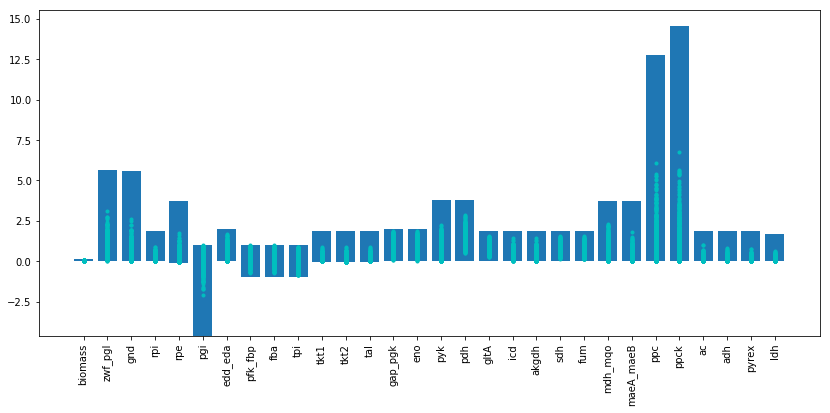

In [66]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.bar(range(fva_df.shape[0]), height=(fva_df.maximum - fva_df.minimum)+2e-2, bottom=fva_df.minimum-1e-2)
ax.set_xticks([i for i in range(fva_df.shape[0])])
ax.set_xticklabels(fva_df.index, rotation=90);
ax.plot(f_smpl[fva_df.index].applymap(nominal_value).transpose(), 'c.');

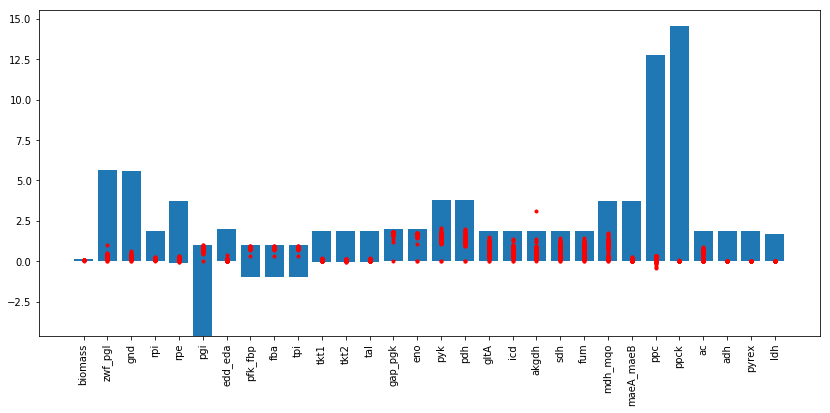

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(14, 6))
ax.bar(range(fva_df.shape[0]), height=(fva_df.maximum - fva_df.minimum)+2e-2, bottom=fva_df.minimum-1e-2)
ax.set_xticks([i for i in range(fva_df.shape[0])])
ax.set_xticklabels(fva_df.index, rotation=90);
ax.plot(rel_ecoli_flux_df[fva_df.index].applymap(nominal_value).transpose(), 'r.');